# Pypam

## 0. Setup

In [1]:
import sys
!pip install pvlib
!pip install lifewatch-pypam==0.3.0
!pip install minio

## 1. Download the data

We will download some processed HMB data to give some examples of how can it be used. 
These data will be downloaded in this jupyterlab space, and you will be able to find them under the /data/ folder, organized by station. 

We will do the same for MARS data

In [2]:
import minio
import os
import pathlib

In [3]:
client = minio.Minio( "s3.us-west-2.amazonaws.com", secure=False)

bucket = 'pacific-sound-spectra'
prefix = '2021/'

local_path = './data'

In [4]:
station = 'MARS'
objects = list(client.list_objects(bucket, prefix=prefix))
ct = len([entry for entry in os.listdir(local_path) if os.path.isfile(os.path.join(local_path, entry))])
for i, obj in enumerate(objects):
    object_name = obj.object_name
    path_name = pathlib.Path(object_name).name
    print(path_name)
    if (not path_name.startswith('.')) & path_name.endswith('.nc'):
        download_path = local_path + '/' + station + '/' + pathlib.Path(object_name).name
        if os.path.isfile(download_path):
            print('Already downloaded: ')
            print(download_path)
        else:
            print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
            ct = ct + 1
            object_data = client.get_object(bucket, object_name)
            if not os.path.isdir(download_path):
                with open(str(download_path), 'wb') as file_data:
                    for data in object_data:
                        file_data.write(data)
            file_data.close()

2021
MARS_20210101.jpg
MARS_20210101.nc
Already downloaded: 
./data/MARS/MARS_20210101.nc
MARS_20210102.jpg
MARS_20210102.nc
Already downloaded: 
./data/MARS/MARS_20210102.nc
MARS_20210103.jpg
MARS_20210103.nc
Already downloaded: 
./data/MARS/MARS_20210103.nc
MARS_20210104.jpg
MARS_20210104.nc
Already downloaded: 
./data/MARS/MARS_20210104.nc
MARS_20210105.jpg
MARS_20210105.nc
Already downloaded: 
./data/MARS/MARS_20210105.nc
MARS_20210106.jpg
MARS_20210106.nc
Already downloaded: 
./data/MARS/MARS_20210106.nc
MARS_20210107.jpg
MARS_20210107.nc
Already downloaded: 
./data/MARS/MARS_20210107.nc
MARS_20210108.jpg
MARS_20210108.nc
Already downloaded: 
./data/MARS/MARS_20210108.nc
MARS_20210109.jpg
MARS_20210109.nc
Already downloaded: 
./data/MARS/MARS_20210109.nc
MARS_20210110.jpg
MARS_20210110.nc
Already downloaded: 
./data/MARS/MARS_20210110.nc
MARS_20210111.jpg
MARS_20210111.nc
Already downloaded: 
./data/MARS/MARS_20210111.nc
MARS_20210112.jpg
MARS_20210112.nc
Already downloaded: 
./da

### 2. Let's look at the data

In [5]:
from pypam.acoustic_survey import ASA
import pypam.utils
import pypam.plots

In [6]:
import pathlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyhydrophone as pyhy

These are the data we can find at [sanctsound](https://console.cloud.google.com/storage/browser/noaa-passive-bioacoustic/sanctsound?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false), daily millidecade bands. 

Let's have a look at it!

For example, we can start loading one daily file to see how it looks. You can click on the document sign or the database sign once the dataset is shown here below to get extra information. 

In [22]:
# Select one of the daily files
ds = xr.open_dataset('./data/MARS/MARS_20210101.nc')
ds.close()

In [23]:
ds

<xarray.Dataset>
Dimensions:      (time: 1440, frequency: 2787)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-01 ... 2021-01-01T23:59:00
  * frequency    (frequency) float32 10.0 11.0 12.0 ... 9.966e+04 9.988e+04
Data variables:
    psd          (time, frequency) float32 ...
    effort       (time) timedelta64[ns] ...
    sensitivity  (frequency) float64 ...
Attributes: (12/29)
    title:                     Hybrid Millidecade Band Sound Pressure Levels ...
    summary:                   To understand natural and anthropogenic sound ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    keywords:                  oceans, ocean acoustics, ambient noise, intens...
    keywords_vocabulary:       GCMD Science Keywords
    history:                   Original hybrid millidecade spectra were produ...
    ...                        ...
    time_coverage_duration:    P1D
    time_coverage_resolution:  P60S
    platform:                  Monterey Accelerated Research System (MARS) ca...
    instrument:                Ocean Sonics icListen HF broadband digital hyd...
    cdm_data_type:             TimeSeries
    references:                Original audio recordings are available open-a...

We can then plot the long-term spectrogram of this day, selecting only the frequencies that we are interested in

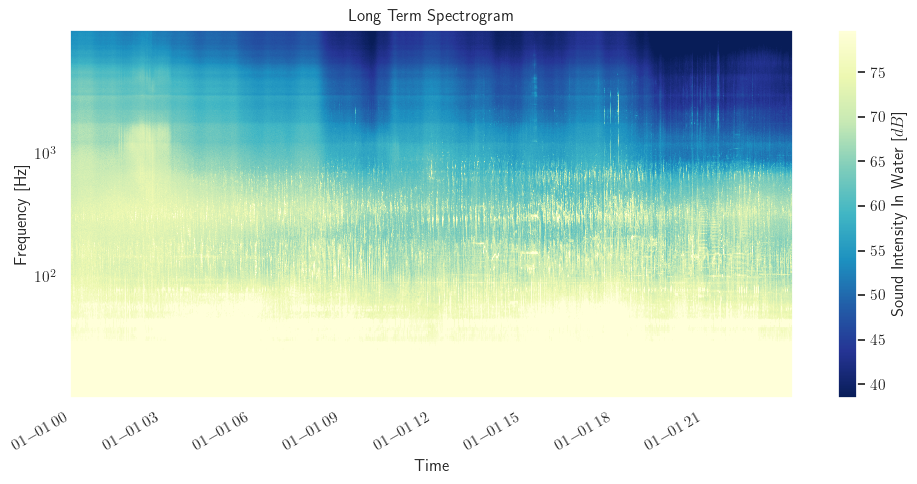

In [24]:
# Select the minimum and the maximum frequency
min_freq = 10
max_freq = 10000

# Plot the LTSA of one day
fig, ax = plt.subplots(figsize=(10, 5))
ds = pypam.utils.select_frequency_range(ds, min_freq=min_freq, max_freq=max_freq, freq_coord='frequency')
pypam.plots.plot_ltsa(ds=ds, data_var='psd', log=True, save_path=None, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
plt.show()

In [26]:
plt.close()

We can also specify the location and then the day/night patter will be shown. But then we need to install the pvblib package

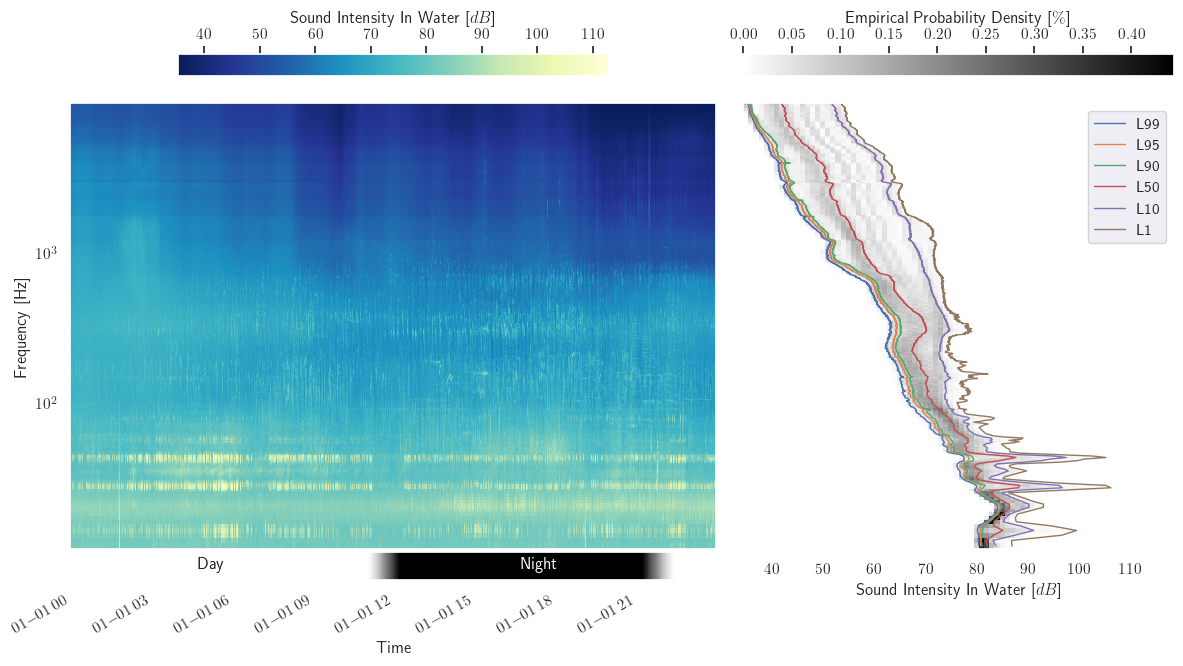

In [27]:
# Lon, Lat
min_psd = 35 # in db
max_psd = 120 # in db
h = 1 # in db
percentiles = [1, 5, 10, 50, 90, 99]
location = [-70.178607, 42.25541] # This is only for SB03, change the values if you change of station to plot
pypam.plots.plot_summary_dataset(ds, percentiles, data_var='psd', time_coord='time', freq_coord='frequency',
                                 min_val=min_psd, max_val=max_psd, show=True, log=True, save_path=None,
                                 location=location)

In [28]:
plt.close()

### 3. Long-term plotting

We will first select some stations to work on, because plotting all the stations at once would take a lot of space and time. 
We selected SB03 and SB01, but if you prefer other just change the list below

Then we can load all the computed daily millidecade bands in one xarray dataset for each station, and we will save the output as one file (a full year per station!). 
For this we will load the data using  the join_all_ds_output_deployment of pypam, which uses Dask parallel computing for fast access. 

We will load only a part of the data (in frequency range), because the MARS data has spectrum values up to 100 kHz, which is too heavy to process all at once in this machine. 

In [38]:
RESAMPLE_RESOLUTION = '1h'
# RESAMPLE_RESOLUTION = '1D'
min_freq = 10
max_freq = 10000

In [39]:
# Only get data from 2021
def load_data_from_station_year(station, year):
    deployment_path = pathlib.Path(local_path).joinpath(station)
    print('loading station %s...' % station)
    aggregated_ds = pypam.utils.join_all_ds_output_deployment(deployment_path, data_vars=['psd'], datetime_coord='time',
                                                              join_only_if_contains='_%s' % year, load=True,
                                                              parallel=False, freq_band=[min_freq, max_freq],
                                                              freq_coord='frequency',
                                                              drop_variables=['psd_image_colormap',
                                                                              'psd_image',
                                                                              'percentile_image',
                                                                              'percentile_image_colormap'])
    if 'quality_flag' in aggregated_ds.data_vars:
        aggregated_ds = aggregated_ds.where(aggregated_ds.quality_flag == 1, drop=True)
    return aggregated_ds # this assigns an xarray dataset

<div class="alert alert-block alert-info">
⚠️ Be patient, loading two full years can take a while...
</div>

In [40]:
# Load all the data
stations_to_load = ['MARS'] # Make a list of 2 stations to compare
ds_collection = {}
for station in stations_to_load:
    ds_collection[station] = load_data_from_station_year(station, 2021)

loading station MARS...
[########################################] | 100% Completed | 4.37 sms


### Plot the HMB as yearly long-term spectrograms

For memory reasons, plotting 1-minute resolution spectrograms for a full year is not possible. Therefore, we need to downsample the data (by taking the median, because values are in db). We can downsample it to hours or days.

<div class="alert alert-block alert-info">
⚠️ Be patient, resampling a full year can take a little while...
</div>

In [41]:
station_to_plot = 'MARS' # By changing these value all the plots below will be for the selected stations

First let's look at how the full dataset looks like (not resampled)

In [42]:
ds_collection[station_to_plot]

<xarray.Dataset>
Dimensions:    (time: 511200, frequency: 1786)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:59:00
  * frequency  (frequency) float32 11.0 12.0 13.0 ... 9.966e+03 9.988e+03
Data variables:
    psd        (time, frequency) float32 81.37 81.75 83.68 ... 53.51 53.27 53.31
Attributes: (12/29)
    title:                     Hybrid Millidecade Band Sound Pressure Levels ...
    summary:                   To understand natural and anthropogenic sound ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    keywords:                  oceans, ocean acoustics, ambient noise, intens...
    keywords_vocabulary:       GCMD Science Keywords
    history:                   Original hybrid millidecade spectra were produ...
    ...                        ...
    time_coverage_duration:    P1D
    time_coverage_resolution:  P60S
    platform:                  Monterey Accelerated Research System (MARS) ca...
    instrument:                Ocean Sonics icListen HF broadband digital hyd...
    cdm_data_type:             TimeSeries
    references:                Original audio recordings are available open-a...

In [43]:
# Need to resample first, otherwise it does not plot!
ds_resampled = ds_collection[station_to_plot].resample(time=RESAMPLE_RESOLUTION).median()

And this is the resampled dataset!

In [44]:
ds_resampled

<xarray.Dataset>
Dimensions:    (frequency: 1786, time: 8760)
Coordinates:
  * frequency  (frequency) float32 11.0 12.0 13.0 ... 9.966e+03 9.988e+03
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    psd        (time, frequency) float32 82.6 82.26 83.54 ... 53.24 53.27 53.29
Attributes: (12/29)
    title:                     Hybrid Millidecade Band Sound Pressure Levels ...
    summary:                   To understand natural and anthropogenic sound ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    keywords:                  oceans, ocean acoustics, ambient noise, intens...
    keywords_vocabulary:       GCMD Science Keywords
    history:                   Original hybrid millidecade spectra were produ...
    ...                        ...
    time_coverage_duration:    P1D
    time_coverage_resolution:  P60S
    platform:                  Monterey Accelerated Research System (MARS) ca...
    instrument:                Ocean Sonics icListen HF broadband digital hyd...
    cdm_data_type:             TimeSeries
    references:                Original audio recordings are available open-a...

We can plot the LTSA also for an entire year

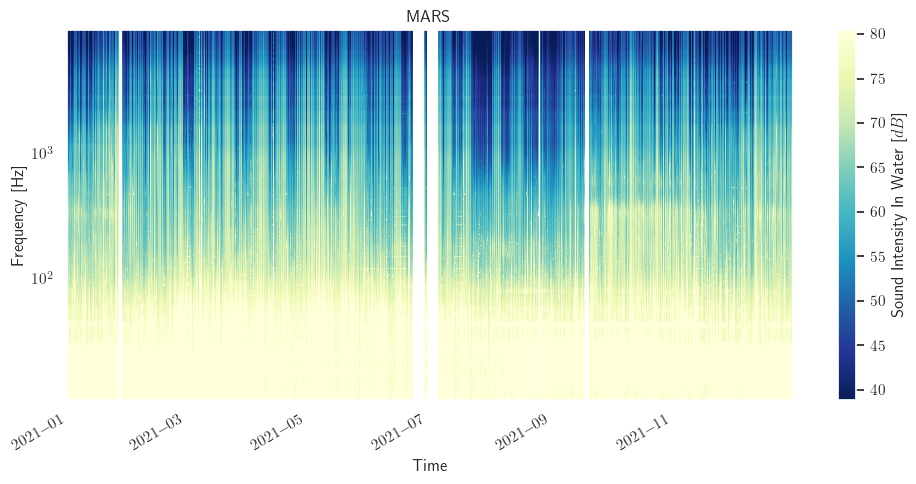

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=ds_resampled, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.set_title(station_to_plot)
plt.show()

In [46]:
plt.close()

### Plot the SPD

In [47]:
# First, convert the HMB output to SPD like we did for the small wav files examples
percentiles = [1, 10, 50, 90, 99]
min_psd = 35 # in db
max_psd = 120 # in db
h = 1 # in db
ds_spd = pypam.utils.compute_spd(ds_resampled, data_var='psd', percentiles=percentiles, min_val=min_psd, 
                                 max_val=max_psd, h=h)

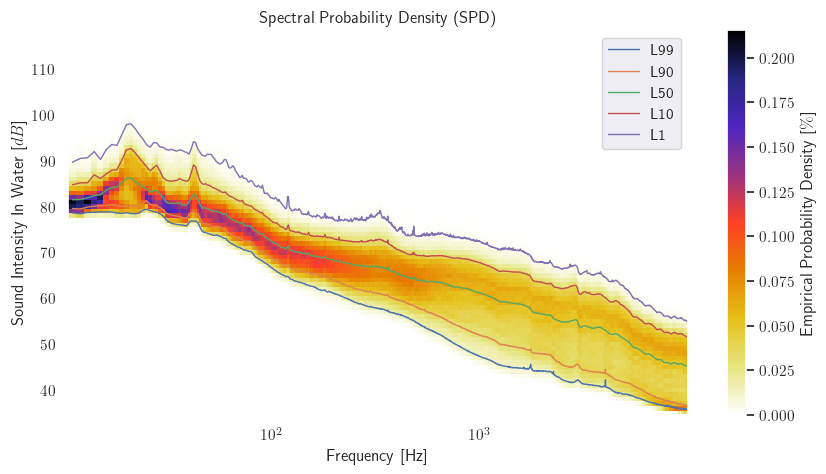

In [48]:
# Plot the obtained output
fig, ax = plt.subplots(figsize=(10,5))
pypam.plots.plot_spd(spd=ds_spd, log=True, save_path=None, ax=ax, show=False)
plt.show()

In [49]:
plt.close()

### Plot a summary

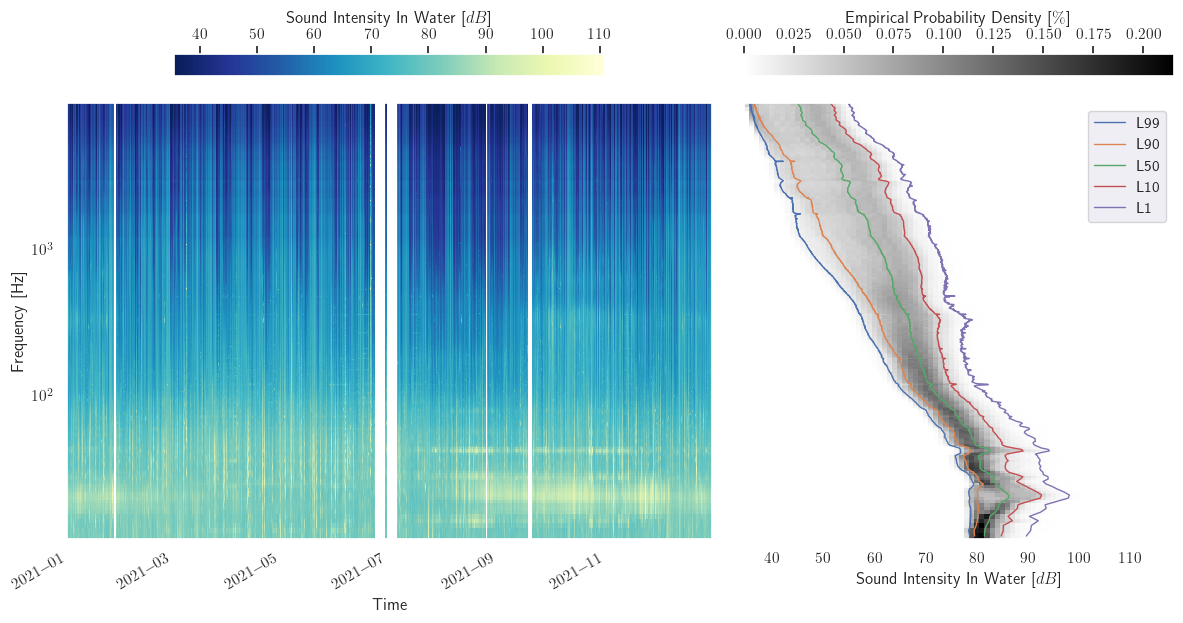

In [50]:
# If we're not interested in the location
pypam.plots.plot_summary_dataset(ds_resampled, percentiles, data_var='psd', time_coord='time', freq_coord='frequency',
                                 min_val=min_psd, max_val=max_psd, show=True, log=True, save_path=None,
                                 location=None)

In [51]:
plt.close()

## 6. Whale presence indices

Indices are the ratio of mean power spectral density (PSD) within the frequency band of peak call energy to mean PSD at background frequencies.
These peak and background frequencies will be illustrated in the summary plot and call index calculations below

In [52]:
# Define the frequencies that are used to compute call indices
bluepeak = np.array([42, 43])
finpeak = np.array([20, 21])
bluebackground = np.array([37, 50])
finbackground = np.array([12, 34])

We can plot a LTSA with a line showing these values, but we will resample it first to daily spectra to get daily indices. 
Be patient, resampling a full year can take a little while...

In [54]:
whale_station1 = 'MARS' # Choose the station you want to plot
daily_resampled1 = ds_collection[whale_station1].resample(time='1D').median()  # Resample to daily spectra

In [55]:
whale_station2 = 'MARS' # Choose the second station you want to plot
daily_resampled2 = ds_collection[whale_station2].resample(time='1D').median()  # Resample to daily spectra

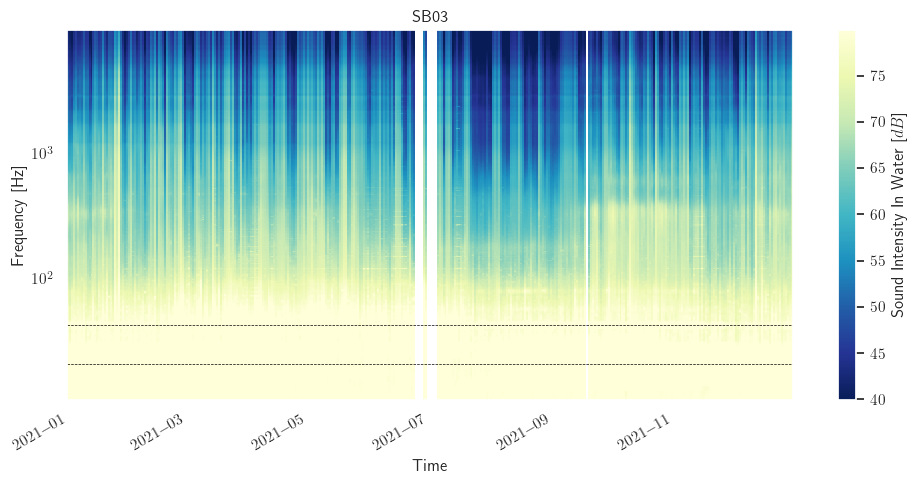

In [56]:
# Then, plot the LTSA
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=daily_resampled1, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.axhline(np.mean(bluepeak),color='black',linestyle='--',linewidth=0.5)
ax.axhline(np.mean(finpeak),color='black',linestyle='--',linewidth=0.5)
ax.set_title('SB03')
plt.show()

In [57]:
plt.close()

In [58]:
def compute_whale_index(peak, background, daily_ds):
    pk = daily_ds.sel(frequency=peak).psd.mean(dim='frequency')
    bg = daily_ds.sel(frequency=background).psd.mean(dim='frequency')
    CI = pk / bg
    return CI

In [59]:
# Compute the whale indices
finCI1 = compute_whale_index(finpeak, finbackground, daily_resampled1)
blueCI1 = compute_whale_index(bluepeak, bluebackground, daily_resampled1)
finCI2 = compute_whale_index(finpeak, finbackground, daily_resampled2)
blueCI2 = compute_whale_index(bluepeak, bluebackground, daily_resampled2)

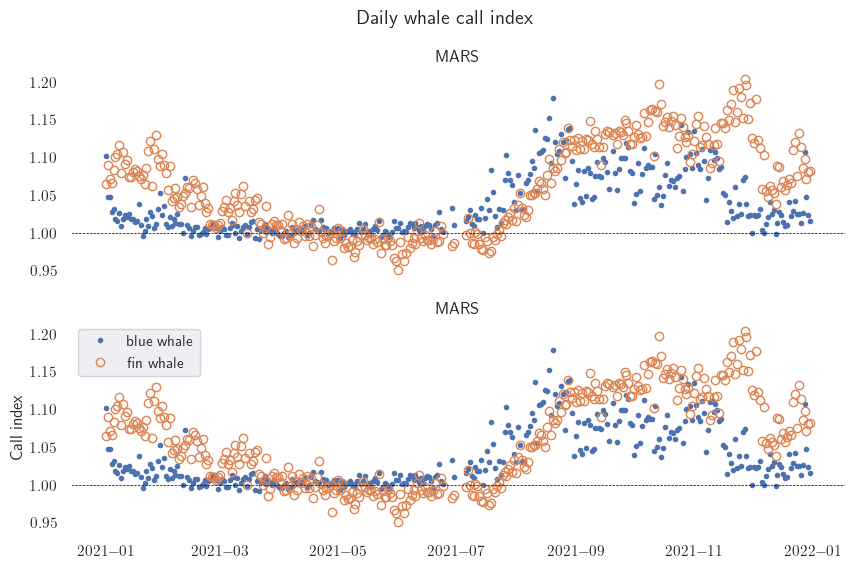

In [60]:
# Plot the whale indices
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True, sharey=True)
ax[0].plot(daily_resampled1.time.values, blueCI1, '.', label='blue whale')
ax[0].plot(daily_resampled1.time.values, finCI1, 'o', markerfacecolor='none', label='fin whale')
ax[0].axhline(1, color='black', linestyle='--', linewidth=0.5)
ax[0].set_facecolor('white')
ax[0].set_title(whale_station1)

ax[1].plot(daily_resampled2.time.values, blueCI2, '.', label='blue whale')
ax[1].plot(daily_resampled2.time.values, finCI2, 'o', markerfacecolor='none', label='fin whale')
ax[1].axhline(1, color='black', linestyle='--', linewidth=0.5)
ax[1].set_facecolor('white')
ax[1].set_title(whale_station2)

plt.suptitle('Daily whale call index')
plt.ylabel('Call index')
plt.legend()
plt.show()

In [61]:
plt.close()

## 7. Daily patterns

We can plot the hourly data we have obtained for the entire year to see if there are any daily patterns which repeat

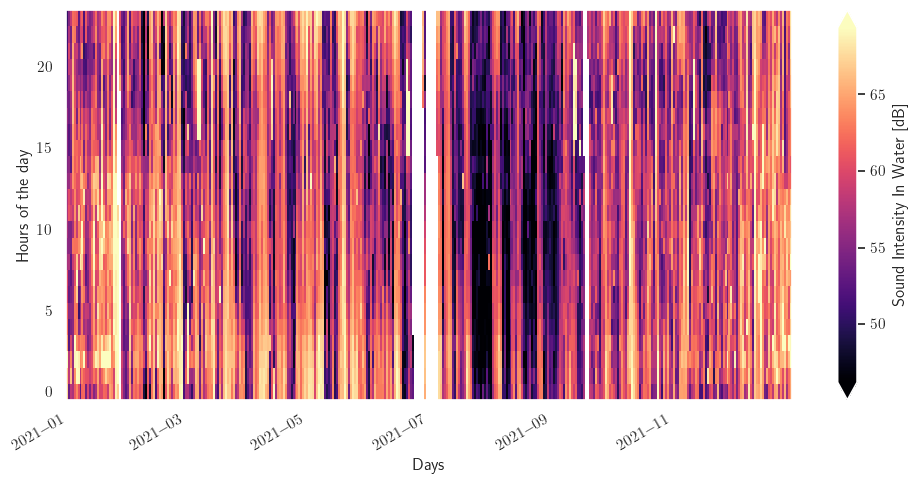

<Axes: xlabel='Days', ylabel='Hours of the day'>

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
ds_freq = pypam.utils.freq_band_aggregation(ds_resampled, data_var='psd', aggregation_freq_band=[10, 20])
pypam.plots.plot_daily_patterns_from_ds(ds=ds_freq, data_var='psd', show=True, datetime_coord='time', ax=ax)

In [63]:
plt.close()

## 8. Compare data between stations

We can compare the spectrums of two locations, by visualizing the median and the [10, 90] percentile spectrum of each location.
We first need to resample it to hourly median resolution for faster plotting. 

<div class="alert alert-block alert-info">
⚠️ Be patient, resampling a two stations can take even a longer while...
</div>

In [64]:
# Spectral Density comparison
ds_collection_resampled = {'SB03': ds_collection['SB03'].resample(time='1H').median(),
                           'MARS': ds_collection['MARS'].resample(time='1H').median()}

KeyError: 'SB03'

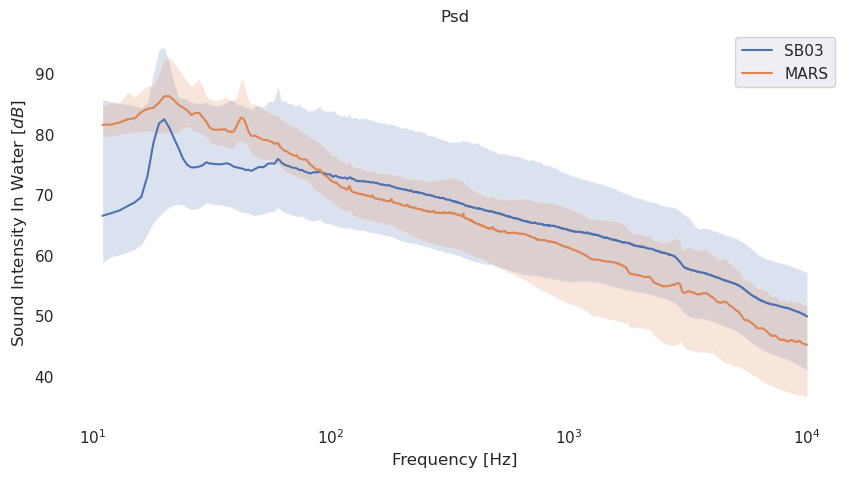

In [48]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})
fig, ax = plt.subplots(figsize=(10, 5))
ax = pypam.plots.plot_multiple_spectrum_median(ds_collection_resampled, 'psd', percentiles='default', 
                                               frequency_coord='frequency',
                                               log=True, save_path=None, 
                                               ax=ax, show=True, time_coord='time')

In [49]:
plt.close()

### Aggregations and boxplots

We can now plot the evolution of all the stations by calling the bin aggregation function. It will compute the median of all the values included in the frequency band specified.
Then it will aggregate all the values of the dataset in time to match the specified time frequency. 
PyPAM has a function to plot the evolution of one or multiple stations. 

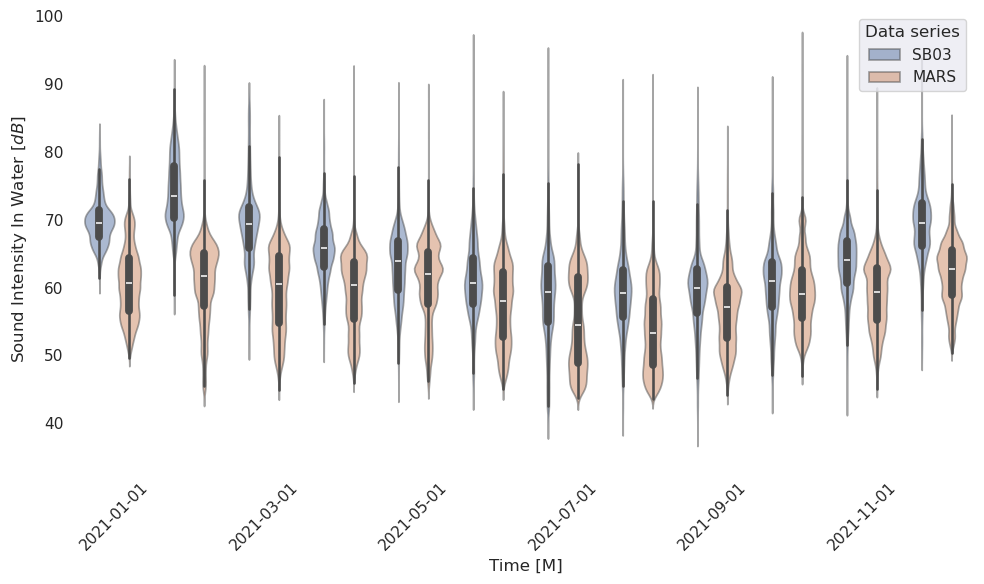

<Figure size 640x480 with 0 Axes>

In [50]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})
aggregation_time = 'M'  # H, D, W, or M (hour, day, week or month)
aggregation_freq_band = [10, 200]
mode = 'violin'  # It can be boxplot, violin or quantiles
fig, ax = plt.subplots(figsize=(10, 6))
ax = pypam.plots.plot_multiple_aggregation_evolution(ds_dict=ds_collection,
                                                     data_var='psd',
                                                     mode=mode,
                                                     show=True,
                                                     datetime_coord='time',
                                                     aggregation_time=aggregation_time,
                                                     freq_coord='frequency',
                                                     aggregation_freq_band=aggregation_freq_band,
                                                     ax=ax,
                                                     alpha=0.5)
ax.set_title('Median sound intensity in water from frequency band %s to %s Hz' %
             (aggregation_freq_band[0], aggregation_freq_band[1]))
plt.tight_layout()

In [65]:
plt.close()

## 9. Conversions: from HMB to decidecade bands

We will work only with one day of data, just to show it (it will be faster!)

In [67]:
ds = xr.open_dataset('./data/MARS/MARS_20210316.nc')

# Convert back to upa for the sum operations
ds['psd'] = np.power(10, ds['psd'] / 10.0 - np.log10(1))

In [68]:
# We have to know the sampling frequency, and nfft will be the same value
fs = 256000
nfft = fs
fft_bin_width = fs / nfft

In [69]:
changing_frequency = 435
bands_limits, bands_c = pypam.utils.get_decidecade_limits(band=[changing_frequency + 1, 256000/2], nfft=nfft, fs=fs)
bands_limits_low, bands_c_low = pypam.utils.get_decidecade_limits(band=[10, changing_frequency], nfft=nfft, fs=fs)

In [70]:
# We need to split the dataset in two, the part which is below the changing frequency and the part which is above
low_psd = ds['psd'].where(ds.frequency <= changing_frequency, drop=True)
low_decidecade = pypam.utils.spectra_ds_to_bands(low_psd, bands_limits_low, bands_c_low, fft_bin_width, db=False)

In [71]:
high_psd = ds['psd'].where(ds.frequency > changing_frequency, drop=True)
high_decidecade = high_psd.groupby_bins('frequency', bins=bands_limits, labels=bands_c, right=True).sum()
bandwidths = np.diff(bands_limits)
high_decidecade = high_decidecade / bandwidths

In [72]:
# Merge the low and the high decidecade psd
decidecade_psd = xr.merge([{'psd': low_decidecade}, {'psd': high_decidecade}])
# Convert back to db
decidecade_psd = 10 * np.log10(decidecade_psd)